In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from scipy.stats import norm

In [60]:
def get_sample(size=10):
    X = np.random.normal(0, 1, size=size)
    y = X + np.random.normal(0, 1, size=size)
    return torch.from_numpy(X[:, None]).float(), torch.from_numpy(y[:, None]).float()

In [61]:
class LinearRegression(nn.Module):
    def __init__(self, in_features=1, bias=True):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(in_features, 1, bias=bias)
        self.var = nn.Linear(in_features, 1, bias=bias)
        
    def forward(self, x):
        return self.linear(x), self.var(x)

In [62]:
def aleatoric_loss(true, pred, var):
    """
    Taken from https://arxiv.org/pdf/1703.04977.pdf
    Theory says we should implement equation (5),
    but practice says equation (8).
    This paper is for computer vision, but the theory behind it applies to
    any neural network model. Here we are using it for NLP.
    Params
    ======
    true: torch tensor
        The true targets
    pred: torch tensor
        The predictions
    var: torch tensor
        The uncertainty of every prediction (actually log(var)).
    """
    loss = torch.exp(-var) * (true - pred)**2 / 2
    loss += 0.5 * var
    return torch.mean(loss)

In [63]:
def train(X, y, aleatoric=False):
    net = LinearRegression(in_features=X.shape[1])

    optim = torch.optim.SGD(net.parameters(), lr=0.0001)
    criterion = nn.MSELoss()
    previous_loss = None
    diff = 1
    pbar = tqdm.tqdm()
    i = 0
    patience = 0
    losses = []
    while True:
        optim.zero_grad()
        pred, var = net(X)
        if aleatoric:
            loss = aleatoric_loss(y, pred, var)
        else:
            loss = criterion(pred, y)
            
        if previous_loss is not None:
            diff = previous_loss - loss.item()
        previous_loss = loss.item()
        losses.append(loss.item())
        pbar.update(1)
        if i % 10000 == 0:
            pbar.set_description("Loss {:.4f}".format(loss.item()))
        if i == 50000:
            optim = torch.optim.SGD(net.parameters(), lr=0.00001)
        if i == 75000:
            optim = torch.optim.SGD(net.parameters(), lr=0.00001)
            
        loss.backward()
        optim.step()
        if diff < 0.00001:
            patience += 1
        else:
            patience = 0
        if patience >= 20 and i >= 100000:
            break
        i += 1
    pbar.close()

    MSE = ((pred - y)**2).mean()
    
    return net, MSE, losses

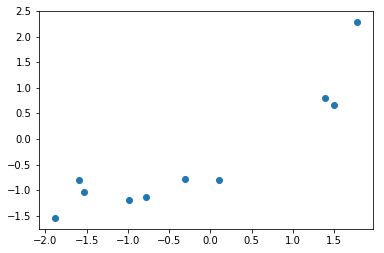

In [64]:
X, y = get_sample(10)
plt.scatter(X.numpy().squeeze(), y.numpy().squeeze())

In [65]:
X_in = X
# X_in = torch.cat([X, X**2], dim=1)

In [66]:
lr, MSE, losses = train(X_in, y)

Loss 0.2590: : 100001it [00:09, 10805.66it/s]


In [67]:
lr_aleatoric, MSE_aleatoric, losses_aleatoric = train(X_in, y, aleatoric=True)

Loss -0.3080: : 100001it [00:16, 6087.28it/s]


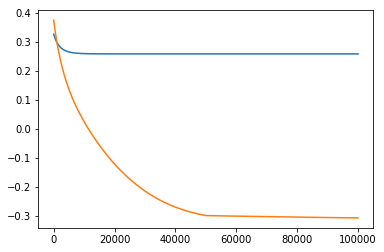

In [68]:
plt.plot(range(len(losses)), losses)
plt.plot(range(len(losses_aleatoric)), losses_aleatoric)

(-5, 5)

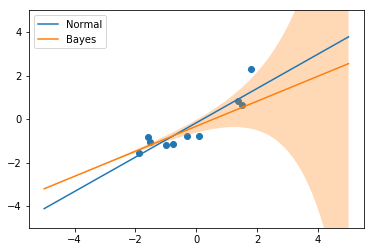

In [77]:
plt.scatter(np.squeeze(X), np.squeeze(y))

x = np.linspace(-5, 5, 100)
x_in = torch.from_numpy(x[:, None]).float()
# x_in = torch.cat([x_in, x_in**2], dim=1)

pred, _ = lr(x_in)
pred = pred.detach().numpy().squeeze()
plt.plot(x, pred)

pred, var = lr_aleatoric(x_in)
pred = pred.detach().numpy().squeeze()
var = np.exp(var.detach().numpy().squeeze())
plt.plot(x, pred)
plt.fill_between(x, pred - var, pred + var, alpha=0.3)
plt.legend(['Normal'.format(MSE), 'Bayes'.format(MSE_aleatoric)])
plt.ylim((-5, 5))
# _ = plt.xlim((-2, 2))